# Technical Solution

## Introduction

In this section the SLAP technical solution is explained. Sail Logging Auto Pilot (SLAP) is a real time control system which uses a GPS heading as the basis for steering a sailing boat.
The steering of the boat is achieved using an actuator (servo motor) to adjust the tiller position. The skipper of the boat activates the auto pilot and the system uses an active control loop to maintain the boats heading. 

The diagram below provides an overview of the system modules and their interactions. The diagram has a close correspondance to the code structure. This technical solution section explains the system's architecture and each of the modules.

![figure1: Slap Architecture](systemArchitecture.drawio.png)

SLAP has two modes of operation. In simulator mode the boat's dynamics, how the boats heading changes over time in response to the tiller action, is mathmatically modelled. In run mode the tiller actuator affects the boats heading according to the actual characteristics of the boat which is reflected in the GPS readout. The diagram illustrates how a user interface is provided via a web server, which interacts with a controller. The controller, in turn, links the tiller actuator to the GPS via a PID controller system. A database is used to store the system's configuration and to act as a logger recording the detail of each trip.

## Overview
The following sections describe each module in outline, full details of their operation and coding are provided below.

### Web Browser
This is the user interface which is the web browser on the user's smartphone. The user connects to the local wifi network on the boat, provided by the Rasberry Pi where the SLAP system is running. There is limited need for security measures since the system is local and not directly connected to the internet. The user accesses the SLAP user interface by entering the IP address of the server into the browser on their smartphone.

### Web Server
The web server hosts the HTML pages and provides the API endpoints for the system. 

### Controller
This is the central coordinating module in the system. It recieves heading data in real time from the GPS, which is forwarded into the PID controller. The output of the PID then drives the tiller actuator module. The controller includes the Proportional, Integral and Differential (PID) feedback system. This PID controller attempts to adjust the baots heading to minimise the difference between the actual heading and the target heading as set by the skipper.

### GPS
The GPS module is a real time system providing a continous update of the boats heading. The GPS module is connected to a hardware GPS board that recieves saterlite data. In 'Simulator Mode' the GPS module returns a heading provided by the boat dynamics simulator module, rather than the actual GPS

### Tiller Actuator
This module recieves tiller angle settings from the PID controller and activates a connected servo motor to drive the tiller. In Simulator Mode this module drives the boat dynamics simulator.

### Boat Dynamics Simulator
This module is used in Simulator Mode to represent the boat's behavour. It is based on the heading changing in response to the tiller action. The mathmatics of this model is based on a first order differential equation.

### SLAP Store
This module is an service interface which interacts with the database to provide access to the system's database. The store is responsible for persisting the system configuration and for logging details of the boat's track (a set of waypoints) 

##### File Structure:

The following file structure is organised inline with the modules described above.

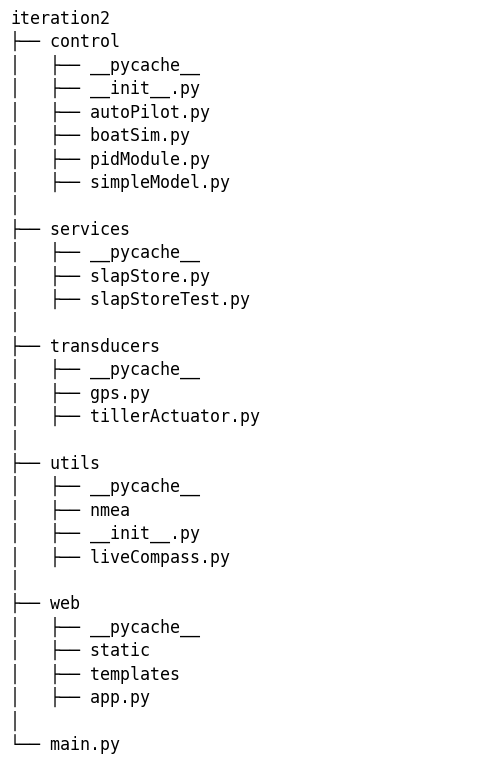

### Packages

The following sections detail the package of code which form the each modules including their operation and the code itself.

### Main.py

This code is the entry point for the program's execution. It starts by instantiating each of the main classes in the system in turn. When a class is created the necessary dependancies are passed in. These dependancies are the solid arrows shown in the system diagram (figure 1). Instantiating the main classes and parsing them into the other classes ensures only a single instance of each is created.

Being a real time system SLAP has a number of program threads running simultanously. main.py as shown below is responsible for starting the various execution threads within the system, these are the Web Server and the GPS.

In [ ]:
# %load ../../../src/iteration2/main.py
from services.slapStore import SlapStore
from control.autoPilot import AutoPilot
from control.boatSim import BoatSim
from web.app import WebServer
from transducers.gps import Gps
from transducers.tillerActuator import TillerActuator
import threading
import time
import atexit

# Used for the discrete time modeling in boatSim
TIMECONSTANT = 0.5

class Main():

    def __init__(self):
        # Init an instance of needed componants
        self.boat_sim = BoatSim(TIMECONSTANT)
        self.gps = Gps(self.boat_sim)
        self.tiller_actuator = TillerActuator(self.boat_sim)
        self.auto_pilot = AutoPilot(self.gps, self.tiller_actuator)

    def main(self):

        # Init Control system
        self.auto_pilot.start()

        # Ensure the controller stops when the application exits
        atexit.register(self.auto_pilot.stop)

        #Create and start Flask web server
        webserver = WebServer(self.auto_pilot)
        app = webserver.create_server()
        app.run(debug=True, use_reloader=False)



if __name__ == '__main__':

    main = Main()
    main.main()

#### Transducers

This package contains the components of the system which take a sensor's output. There are two transducer files, gps.py and tillerActuator.py. 
gps.py simply returns a NMEA string for heading. As we are using a simulated boat and GPS, the gps.py must encode the actual heading from the boat into a NMEA string to emulate the real world GPS.

##### gps.py
The actual GPS module supplies heading, position and speed data using a protocol called NMEA. This is a string based format where information is encoded in 'sentences'

In [ ]:
# %load ../../../src/iteration2/transducers/gps.py

# gps.py

from control.boatSim import BoatSim
from utils.nmea.nmeaEncoder import Encoder

class Gps:
    def __init__(self, boat_sim: BoatSim):
        # Import the instance of the boat simulator
        # Import the encoding functions I made
        self.boat_sim = boat_sim
        self.encoder = Encoder()

    def getHeading(self):
        # Returns encoded heading
        return self.encoder.encode_Angle(self.boat_sim.getHeading())


##### tillerActuator.py
The tiller actuator is used to turn the variables in the system into a usable motor control signals to the physically turn the rudder. However boat tillerActuator.py changes and sets the angle of the simualted rudder, which in turn affect the heading of the boat simulation code


In [ ]:
# %load ../../../src/iteration2/transducers/tillerActuator.py

# tillerActuator.py

from control.boatSim import BoatSim


class TillerActuator:

    def __init__(self, boat_sim: BoatSim):
        # Import boat sim instance
        self.boat_sim = boat_sim


    def setAngle(self, angle):
        # Preforms one iteration of the boat dynamics
        # to find the next angle on discrete time
        self.boat_sim.update(angle)
'''
TODO: Add if statements when in Run Mode to activate real motor
'''

#### Web Server

This package contains the components that run the web server and allow it to interact with the rest of the system:
This module contains all the HTML files to be served to the client, the javascript and all images used.

The web server (app.py) has two main functions.
1. Serving HTML files: These HTML files are the user interfaces which are presented on the user's smartphone.

    - The main navigation page 

    - The configuration page

2. Providing HTTP methods: These are the API calls used by the browser to interact with the system they are:

    - Adjusting the course

    - Getting updates for presentation to the user

In [ ]:
# app.py

# %load ../../../src/iteration2/web/app.py
from flask import Flask, request, render_template, jsonify, g
from services.slapStore import SlapStore
from services.slapStore import Boat
from control.autoPilot import AutoPilot
import threading
import queue
import time

class WebServer:

    def __init__(self, auto_pilot: AutoPilot):
        # Importing the Auto Pilot instance
        self.auto_pilot = auto_pilot
        

    def create_server(self):

        # Creating instances of Flask and the Database service
        app = Flask(__name__)
        store = SlapStore()

        @app.route("/")
        def home():
            # Default Route
            return render_template('changeangle.html')

        @app.route("/config")
        def config():
            # Route for adding a boat
            return render_template('config.html')

        @app.route('/api/setDirection', methods=['PUT'])
        def setDirection():
            try:
                # Sets the target heading based on users input in web page
                # Get data from request
                heading = request.get_data().decode('utf-8')
                print("Received data:", heading)

                # Update desired heading, returns the new actual heading
                heading = self.auto_pilot.setHeading(int(heading))

                # Return JSON response
                response_data = {"angle": str(heading)}
                print("Heading", response_data)

                return jsonify(response_data), 200

            except Exception as e:
                print(f"Error processing setDirection request: {str(e)}")
                return jsonify({"error": str(e)}), 400
            
        @app.route('/api/headings', methods=['GET'])
        def get_headings():
            # Returns Headings (Target and Actual)
            return jsonify(self.auto_pilot.getHeadings())
    

        @app.route('/api/addDirection', methods=['PUT'])
        def addDirection():
            try:
                # increments the target heading based on users input in web page
                # Get data from request
                change = request.get_data().decode('utf-8')
                print("Received data:", heading)

                # Update desired heading, returns the new actual heading
                heading = self.auto_pilot.getHeading()
                heading += change
                heading = self.auto_pilot.setHeading(heading)

                # Return JSON response
                response_data = {"angle": heading}
                print("Heading", response_data)

                return jsonify(response_data), 200


            except Exception as e:
                print(f"Error processing request: {str(e)}")
                return jsonify({"error": str(e)}), 400
            

        return app

##### HTML Files
These are served to the client when requested. The main page provides controls to start and stop logging and to adjust the target heading. It provides a compass displaying the target and actual headings in a graphical format.
It uses Scaleable Vector Graphics (SVG) to draw the heading lines over a compass image.
This HTML page imports javascript code that connects with the web server interface.

In [ ]:
<!-- %load ../../../src/iteration2/web/templates/changeangle.html -->
<html>
<!--                     This imports the JavaScript code                   -->
<script src="{{ url_for('static', filename='js/angle.js') }}"></script>


<head>
    <title>Change Value</title>
</head>

<body>
    <div>
        Angle = <div id="angle">0</div>
    </div>
    <button onclick="changeValue(10)">+10</button>
    <!-- These buttons run the changeValue function in the javascript-->
    <button onclick="changeValue(-10)">-10</button><br><br>

    <label for="directionSet">Set Direction:</label>
    <input type="int" id="directionSet" name="directionSet">
    <button onclick="setValue(parseInt(document.getElementById('directionSet').value))">Set Direction</button><br><br>
    <!-- This the is the SVG to display the compass and the two lines -->
    <svg width="200" height="200" xmlns="http://www.w3.org/2000/svg" >
       <image href="{{ url_for('static', filename='images/compass-rose.png') }}" x="0" y="0" width="200" height="200"/> 
        <line id = target
              x1="100" y1="100" 
              x2="100" y2="50" 
              style="stroke:rgb(255, 0, 0);stroke-width:2"
              transform="rotate(0, 50, 50)" />
        <line id = actual 
              x1="100" y1="100" 
              x2="100" y2="50" 
              style="stroke:rgb(0, 0, 255);stroke-width:2"
              transform="rotate(0, 50, 50)" />
      </svg>
</body>

</html>

##### JavaScript
This JavaScript is responsible for the function in the web browser that interacts with the server.

1. Its interactions with the web server in response to the user's interactions

2. It has a polling loop to continously retrieve updates from the server on the current heading and update the user interface.

In [ ]:
// %load ../../../src/iteration2/web/static/js/angle.js
// Functions for reacting to button presses


function changeValue(c) {
    const url = '/api/addDirection'; 
    console.log("Inside changeValue", c);

    fetch(url, {
        method: "PUT",
        headers: {
            "Content-Type": "text/plain"  // Changed from text/html
        }, 
        body: c.toString() 
    })
        .then(response => {
            if (!response.ok) {
                throw new Error(`HTTP error! status: ${response.status}`);
            }
            return response.json();
        })
        .then(data => {
            console.log("Received response:", data);
            document.getElementById("angle").textContent = data.angle;
            updateLine(data.angle)
        })
        .catch(error => {
            console.error("Error:", error);
            document.getElementById("angle").textContent = 
                "Error: " + error.message;
        });
}

function setValue(c) {
    const url = '/api/setDirection'; 
    console.log("Inside changeValue", c);

    fetch(url, {
        method: "PUT",
        headers: {
            "Content-Type": "text/plain"  // Changed from text/html
        },
        body: c.toString()  // Send the raw value instead of JSON.stringify
    })
        .then(response => {
            if (!response.ok) {
                throw new Error(`HTTP error! status: ${response.status}`);
            }
            return response.json();
        })
        .then(data => {
            console.log("Received response:", data);
            document.getElementById("angle").textContent = data.angle;
        })
        .catch(error => {
            console.error("Error:", error);
            document.getElementById("angle").textContent = 
                "Error: " + error.message;
        });
    }
            // Update the linear compass for the actual heading
function updateHeading(a){
    console.log("update Heading: ", a)
    line = document.getElementById("actual")
    line.setAttribute("transform", `rotate(${a}, 100, 100)`);

}
            // update the line on the compass for the target heading
function updateTarget(a){
    console.log("update Target: ", a)
    line = document.getElementById("target")
    line.setAttribute("transform", `rotate(${a}, 100, 100)`);

}

// Update the compass by getting the values from the server
async function updateCompass() {
    const response = await fetch('/api/headings');
    console.log(response)
    const readings = await response.json();
    updateTarget(readings.target)
    updateHeading(readings.actual)
    
}

// Initial load
updateCompass();

// Update readings
setInterval(updateCompass, 200);

#### Control Package

This package contains the PID and the boat simulator systems. It contains four files; autoPilot.py, boatSim.py, pidModule.py and simpleModel.py

At the centre of the control package is the auto pilot code, which links the GPS to the tiller actuator via the PID controller. As shown in figure 1

##### autoPilot.py
autoPilot.py is the main boat controller. It reads the GPS to find out the current heading and the target heading whcih are fed to the PID algorithm. The PID algorithm uses the PID contants and the equation to calculate a new tiller actuator position. This is fed to the actuator to control the rudder angle. It also contains start / stop functions to start the system or disable it. It contains set and get functions for the headings.

In [ ]:
# %load ../../../src/iteration2/control/autoPilot.py
import control.pidModule
from services.slapStore import SlapStore
from control.pidModule import PidController
from transducers.gps import Gps
from transducers.tillerActuator import TillerActuator
from threading import Thread
from utils.nmea.nmeaDecoder import Decoder

class AutoPilot():

    def __init__(self, gps: Gps, tiller_actuator: TillerActuator):
        # Imports all the needed instances for the controller
        # Creates all needed variable for the controller
        self.running = False
        self.thread = None
        self.data_store = SlapStore()
        self.pid_controller = PidController(1,0,0)
        self.gps = gps
        self.tiller_actuator = tiller_actuator
        self.target_heading = 0
        self.decoder = Decoder()
        self.actual_heading = 0


    def setHeading(self,input):
        # set Heading to the input
        self.target_heading = input
        return self.target_heading
    
    def getHeadings(self):
        # Returns a dictionary of both heading values
        headings = {
            'target': self.target_heading,
            'actual': self.actual_heading
        }
        return headings

    def control_loop(self):
        # Preforms one iteration of the control loop
        while self.running:
            self.actual_heading = self.gps.getHeading()
            # Recieves heading and decodes the NMEA string
            self.actual_heading = self.decoder.decodeAngle(self.actual_heading)
            # Preforms one iteration of the PID controller
            angle = self.pid_controller.pid(self.actual_heading, self.target_heading, 0.01)
            # Sets the new rudder angle to the output
            self.tiller_actuator.setAngle(angle)



    def start(self):
        # Starts the control system on a new thread
        if not self.running:
            self.running = True
            self.thread = Thread(target=self.control_loop, daemon=True)
            self.thread.start()
    
    def stop(self):
        # Stops the system
        self.running = False 

##### simpleModel.py

simpleModel.py contains the mathmatics for one iteration of the boat dynamics on discrete time with a given rudder angle and starting heading.

In [ ]:
# %load ../../../src/iteration2/control/simpleModel.py
import math
import sys
import os

def iterate_Heading(heading, rudderAngle, timeConstant):
    k = 0
    #integrating constant
    # Preforms simple equation to iterate the heading and returns the output
    newHead = heading + rudderAngle * math.log(abs(timeConstant)) + k
    return newHead

'''
The code here is for the first order differential equation which is a better model of the boat behavour.
TODO: Fix up first order maths and put code here to make a more realistic boat simulator
'''

##### pidModule.py
pidModule.py is a PID function with takes the current heading, target heading and the gains for each aspect (proportional, integral and differential).
The PID module works by taking the error (distance between the target heading and current heading), adding that to the integral of the error so as the current heading sits apart from the target heading the area under the error-time graph will increase, causing the output to increase. This is then added to the differential, where the differential of the error is taken, also known as the rate of change of heading, this being the gradient of the heading-time graph. The use of differential allows us to measure the speed that we are heading towards the target heading, meaning we can dampen the speed as we get nearer the target.
The addition of all these gives us the function to take the current and target heading and get an output which can adjust the rudder to get us closer to the target heading.

In [ ]:
# %load ../../../src/iteration2/control/pidModule.py

#          pidModule.py

class PidController:

    def __init__(self,KP,KI,KD):
        # Imports the gains to be used
        self.kp = KP
        self.ki = KI
        self.kd = KD
        self.accumlatedError = 0
        self.lastPos = 0
        self.elapsed = 0

    def pid(self, pos: int, target: int, dt: float):

        # PROPORTIONAL-------
        error = target - pos
        proportional = error

        # Intergral----------
        intergal = ((error * dt) + self.accumlatedError)
        self.accumlatedError = intergal


        # Differential-------
        dpos = self.lastPos - pos
        differential = (dpos / dt)
        # Stores the previous position
        # to use in the differential equation next time it is run
        self.lastPos = pos
        # Returns the addition of all these values adjusted using the gains
        return self.kp * proportional + self.ki * intergal + self.kd * differential

##### boatSim.py
boatSim.py contains the 'simulated boat'. This means it contains all the boat dynamics to all iteration of the simulator using simpleModel.py and makes the output of this something we can use in pidModule.py. It also contains a getHeading function to return the current heading.


In [ ]:
# %load ../../../src/iteration2/control/boatSim.py
from .simpleModel import iterate_Heading as iterate
import msvcrt
import sys
import os
class BoatSim:

    def __init__(self, time_constant):
        # Imports constants and contains the heading variable
        self.time_constant = time_constant
        self.heading = 0

    def update(self, rudderAngle):
        # Preforms one iteration of the boats movements and ensures its a usable value
        self.heading = iterate(self.heading, rudderAngle, self.time_constant)
        self.heading = round(self.heading)
        if self.heading >= 360:
            self.heading = self.heading - 360
        elif self.heading <= 0:
            self.heading = 360 + self.heading
       
    
    def getHeading(self):
        # Returns the current heading
        return self.heading
    
if __name__ == "__main__":
    simulator = BoatSim()
    while True:
        simulator.update(1, 0.5)
        print(simulator.getHeading())

#### Services

This package contains the database and storage.
The file called slapStore contains all the service functions to interact with the database. This module contains the entities within the database model as shown in figure 2. It also contains a collection of service methods that access the database. The design pattern of this package is known as a [Service Fascade](https://en.wikipedia.org/wiki/Facade_pattern). The purpse of this package is to provide the methods the program requires whilst hiding the complexity and implementation of the database from the rest of the program.


In [ ]:
# %load ../../../src/iteration2/services/slapStore.py
import sqlite3


# --- All Classes possible to put into the database ---
class Boat():

    def __init__(self, id: int,  name: str, model: str, proportional: int, integral: int, differential: int):
        # Contains and assigns the values for the Boat type
        self.name = name
        self.boatId = id
        self.model = model
        self.proportional = proportional
        self.integral = integral
        self.differential = differential

class Sensor():

    def __init__(self, id: int, boat: int, name: str, model: str):
        # Contains and assigns the values for the Sensor type
        self.sensorId = id
        self.boatId = boat
        self.sensorName = name
        self.sensorModel = model

class Trip():
    def __init__(self, trip_id: int, boat_id: int, time_started: str, time_ended: str, date_started: str, date_ended: str, distance_travelled: float):
        # Contains and assigns the values for the Trip type
        self.tripId = trip_id
        self.boatId = boat_id
        self.timeStarted = time_started
        self.timeEnded = time_ended
        self.dateStarted = date_started
        self.dateEnded = date_ended
        self.distanceTravelled = distance_travelled

class Reading():
     # Contains and assigns the values for the Reading type
    def __init__(self, sensor_id: int, trip_id: int, data: float, timestamp: str):
        self.sensorId = sensor_id
        self.tripId = trip_id
        self.data = data
        self.timeStamp = timestamp

        
class SlapStore():
       
    def __init__(self):
        # Set up database and creates all necessary tables
        print("Creating Database")
        self.connection = sqlite3.connect("slap.db")
        self.cursor = self.connection.cursor()

        # Boat table
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS BOATS (
                boatId INTEGER PRIMARY KEY,
                boatName TEXT NOT NULL,
                boatModel TEXT NOT NULL,
                proportional INTEGER NOT NULL,
                integral INTEGER NOT NULL,
                differential INTEGER NOT NULL
            )
        ''')

        # Sensor table
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Sensor (
                sensorId INTEGER PRIMARY KEY,
                boatId INTEGER NOT NULL,
                sensorName TEXT NOT NULL,
                sensorType TEXT NOT NULL,
                dataType TEXT NOT NULL,
                FOREIGN KEY (boatId) REFERENCES BOATS(boatId) ON DELETE CASCADE
            )
        ''')

        # Trip table
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Trip (
                tripId INTEGER,
                boatId INTEGER NOT NULL,
                timeStarted TEXT NOT NULL,
                timeEnded TEXT NOT NULL,
                dateStarted DATE NOT NULL,
                dateEnded DATE NOT NULL,
                distanceTravelled FLOAT NOT NULL,
                PRIMARY KEY (tripId, boatId),
                FOREIGN KEY (boatId) REFERENCES BOATS(boatId) ON DELETE CASCADE
            )
        ''')

        # Reading table
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Reading (
                sensorId INTEGER NOT NULL,
                tripId INTEGER NOT NULL,
                data FLOAT NOT NULL,
                timeStamp TIME NOT NULL,
                FOREIGN KEY (sensorId) REFERENCES Sensor(sensorId) ON DELETE CASCADE,
                FOREIGN KEY (tripId) REFERENCES Trip(tripId) ON DELETE CASCADE
            )
        ''')

        self.connection.commit()

#        ---All service functions for the database---

    def addBoat(self, boat: Boat): 
        # Inserts a boat into the database
        self.cursor.execute(f"INSERT INTO BOATS (boatId, boatName, boatModel, proportional, integral, differential) VALUES ('{boat.boatId}','{boat.name}','{boat.model}','{boat.proportional}','{boat.integral}','{boat.differential}')")
        self.connection.commit()
    
    def getGains(self,id: int):
        # Returns all PID gains stored in the Boat instance
        gains = {}
        # Retrieves all data and stores it as a dictionary
        self.cursor.execute(f"SELECT proportional, integral, differential FROM BOATS WHERE boatId = '{id}'")
        columns = [desc[0] for desc in self.cursor.description]
        for row in self.cursor.fetchall():
            row_dict = dict(zip(columns, row))
            gains = row_dict 
        return gains

    def getBoat(self,name: str):
        # Returns all information on a boat using its name as the identifier
        self.cursor.execute(f"SELECT * FROM BOATS WHERE boatName == '{name}'")
        row = self.cursor.fetchone()
        return row
    
    def addSensor(self, sensor: Sensor): 
        # Inserts a Sensor into the database
        self.cursor.execute(f"INSERT INTO Sensor (sensorId, boatId, sensorName, sensorType, dataType) VALUES ('{sensor.sensorId}', '{sensor.boatId}', '{sensor.sensorName}', '{sensor.sensorModel}', 'N/A')")
        self.connection.commit()

    def getSensor(self, sensor_name: str):
        # Returns all information on a sensor using its name
        self.cursor.execute(f"SELECT * FROM Sensor WHERE sensorName == '{sensor_name}'")
        row = self.cursor.fetchone()
        return row

    def addTrip(self, trip: Trip):
        # Inserts a Trip into the database  
        self.cursor.execute(f"INSERT INTO Trip (tripId, boatId, timeStarted, timeEnded, dateStarted, dateEnded, distanceTravelled) VALUES ('{trip.tripId}', '{trip.boatId}', '{trip.timeStarted}', '{trip.timeEnded}', '{trip.dateStarted}', '{trip.dateEnded}', '{trip.distanceTravelled}')")
        self.connection.commit()

    def getTrip(self, trip_id: int, boat_id: int):
        # returns all information on a trip using the tripId and BoatId as the identifier
        self.cursor.execute(f"SELECT * FROM Trip WHERE tripId == {trip_id} AND boatId == {boat_id}")
        row = self.cursor.fetchone()
        return row

    def addReading(self, reading: Reading):
        # Inserts a Reading into the database    
        self.cursor.execute(f"INSERT INTO Reading (sensorId, tripId, data, timeStamp) VALUES ('{reading.sensorId}', '{reading.tripId}', '{reading.data}', '{reading.timeStamp}')")
        self.connection.commit()

    def getReading(self, sensor_id: int, trip_id: int):
        # Returns all Reading information using the sensorId and TripId as identifiers
        self.cursor.execute(f"SELECT * FROM Reading WHERE sensorId == {sensor_id} AND tripId == {trip_id}")
        row = self.cursor.fetchone()
        return row
    
    def getAllReadings(self):
        # Prints all readings from any sensor 
        self.cursor.execute(f"SELECT * FROM Reading")
        for row in self.cursor.fetchall():
            print(row)

    def dropAllTables(self):
        # Deletes all tables
        self.cursor.execute(f"DROP TABLE *")


#### Database

The database is used to store information about all the trips a boat has preformed including information about the boad, sensors and readings.

The Boat table includes all the attributes of the boat, such as its name, model and the PID tuning information.

The Sensor table stores the information about a specific sensor. Such as its name, model, its datatype and its associated boat 

The Reading table stores a single reading from a sensor. it only stores the data value and timestamp.

The Trip table stores all the information about a single trip, including the associated boat, its start and end data, time and the distance travelled.

Below is the entity relationship diagram for the SLAP database.

Figure 2

![figure 2: Slap Entity Relationship Diagram](erd.drawio.png)